# Audio Reconstruction Using Linear Regression and Random Fourier Features

In [1]:
import torch
import torchaudio
from IPython.display import Audio

import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

cpu


In [2]:
# Importing the audio file

audio, sample_rate = torchaudio.load("/kaggle/input/sounds/sound.mp3")
print(audio.shape)
print(sample_rate)

torch.Size([2, 1332224])
44100


In [3]:
audio = audio[0]
time = audio.shape[0] / sample_rate
print(f"Audio length: {time} seconds")

Audio length: 30.209160997732425 seconds


In [4]:
# Trimming the audio file down to first 5 seconds

audio = audio[:int(5*sample_rate)]
time = audio.shape[0] / sample_rate
print(f"Audio length: {time} seconds")

Audio length: 5.0 seconds


In [5]:
audio, audio.max(), audio.min()

(tensor([0.0000, 0.0000, 0.0000,  ..., 0.2784, 0.2774, 0.2641]),
 tensor(0.9349),
 tensor(-0.8681))

In [6]:
def plot_audio(audio, sample_rate, color, title):
    plt.figure(figsize=(15, 5))
    plt.plot(audio, color = color, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sample_rate), np.arange(0, audio.shape[0] / sample_rate, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.grid()
    plt.show()

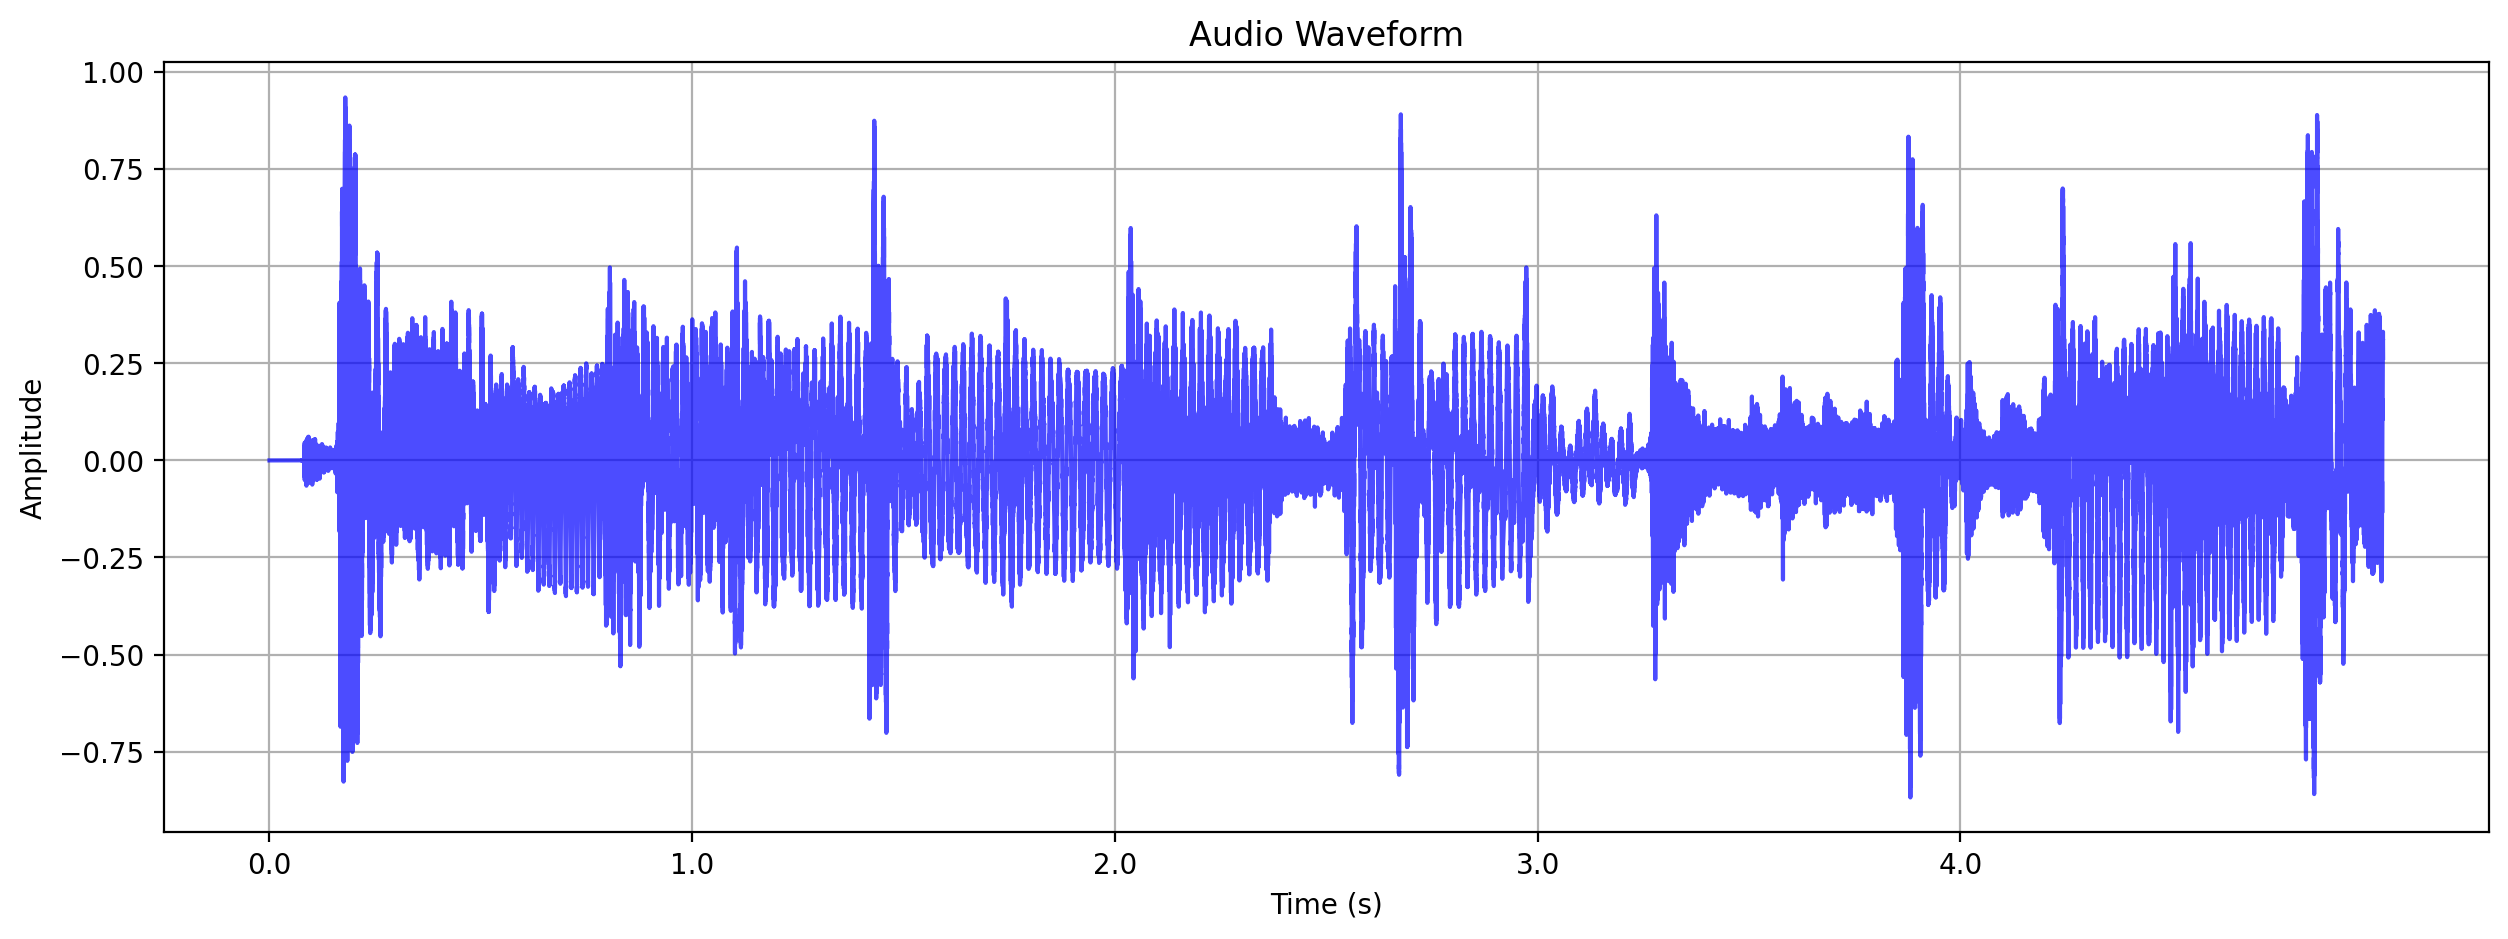

In [7]:
plot_audio(audio, sample_rate, 'blue', 'Audio Waveform')

In [8]:
# Shifting the domain of the time series to [-100,100]

X = torch.arange(0, len(audio)).unsqueeze(1).float()
X = X/X.max()*200-100
print(X.shape)
print(X)

torch.Size([220500, 1])
tensor([[-100.0000],
        [ -99.9991],
        [ -99.9982],
        ...,
        [  99.9982],
        [  99.9991],
        [ 100.0000]])


In [9]:
Audio(audio, rate = sample_rate)

In [10]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    """
    X: torch.Tensor of shape (num_samples, 2)
    num_features: int
    sigma: float
    """
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=1)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device), rff

In [11]:
num_features = 25000
sigma = 0.008

X_rff, _ = create_rff_features(X, num_features, sigma)
print(X_rff.shape)
print(X_rff)

torch.Size([220500, 25000])
tensor([[-3.5542e-03,  3.0244e-03, -8.9307e-03,  ..., -1.4592e-03,
          8.4604e-03, -4.5001e-03],
        [-1.9960e-03,  2.4340e-03, -8.8851e-03,  ..., -2.4558e-03,
          8.4491e-03, -4.3464e-03],
        [-3.5327e-04,  1.8319e-03, -8.8075e-03,  ..., -3.4284e-03,
          8.4376e-03, -4.1891e-03],
        ...,
        [-3.2479e-03, -1.3676e-03,  8.8853e-03,  ...,  4.4800e-03,
          3.8997e-04, -1.1009e-04],
        [-1.6375e-03, -1.9810e-03,  8.8070e-03,  ...,  5.3474e-03,
          4.2487e-04, -2.9128e-04],
        [-2.2145e-05, -2.5763e-03,  8.6984e-03,  ...,  6.1236e-03,
          4.5922e-04, -4.6582e-04]])


In [12]:
X_rff.shape, audio.shape

(torch.Size([220500, 25000]), torch.Size([220500]))

In [13]:
audio = audio.unsqueeze(1)  # Reshape audio to have shape (220500, 1)
audio.shape

torch.Size([220500, 1])

In [14]:
model = LinearRegression()
model.fit(X_rff.cpu().numpy(), audio.cpu().numpy())

pred_audio = model.predict(X_rff.cpu().numpy())
print(pred_audio.shape)

(220500, 1)


In [15]:
print(pred_audio)
print(audio)

[[-0.03698895]
 [-0.02433987]
 [-0.01422017]
 ...
 [ 0.2909052 ]
 [ 0.28797713]
 [ 0.28393516]]
tensor([[0.0000],
        [0.0000],
        [0.0000],
        ...,
        [0.2784],
        [0.2774],
        [0.2641]])


In [16]:
# Finding reconstruction losses (L1 and L2 Norms)

np.linalg.norm(pred_audio - audio.numpy()), np.linalg.norm((pred_audio - audio.numpy()), ord = 1)

(np.float32(18.192984), np.float32(5876.752))

In [17]:
print(pred_audio.shape)

(220500, 1)


In [18]:
pred_audio = pred_audio.squeeze()
print(pred_audio.shape)

# Normalize the predicted audio to [-1, 1] range
pred_audio = pred_audio / np.max(np.abs(pred_audio))

# # Convert to NumPy array if it's still a tensor
# pred_audio = pred_audio.cpu().numpy()

Audio(pred_audio, rate=sample_rate)

(220500,)


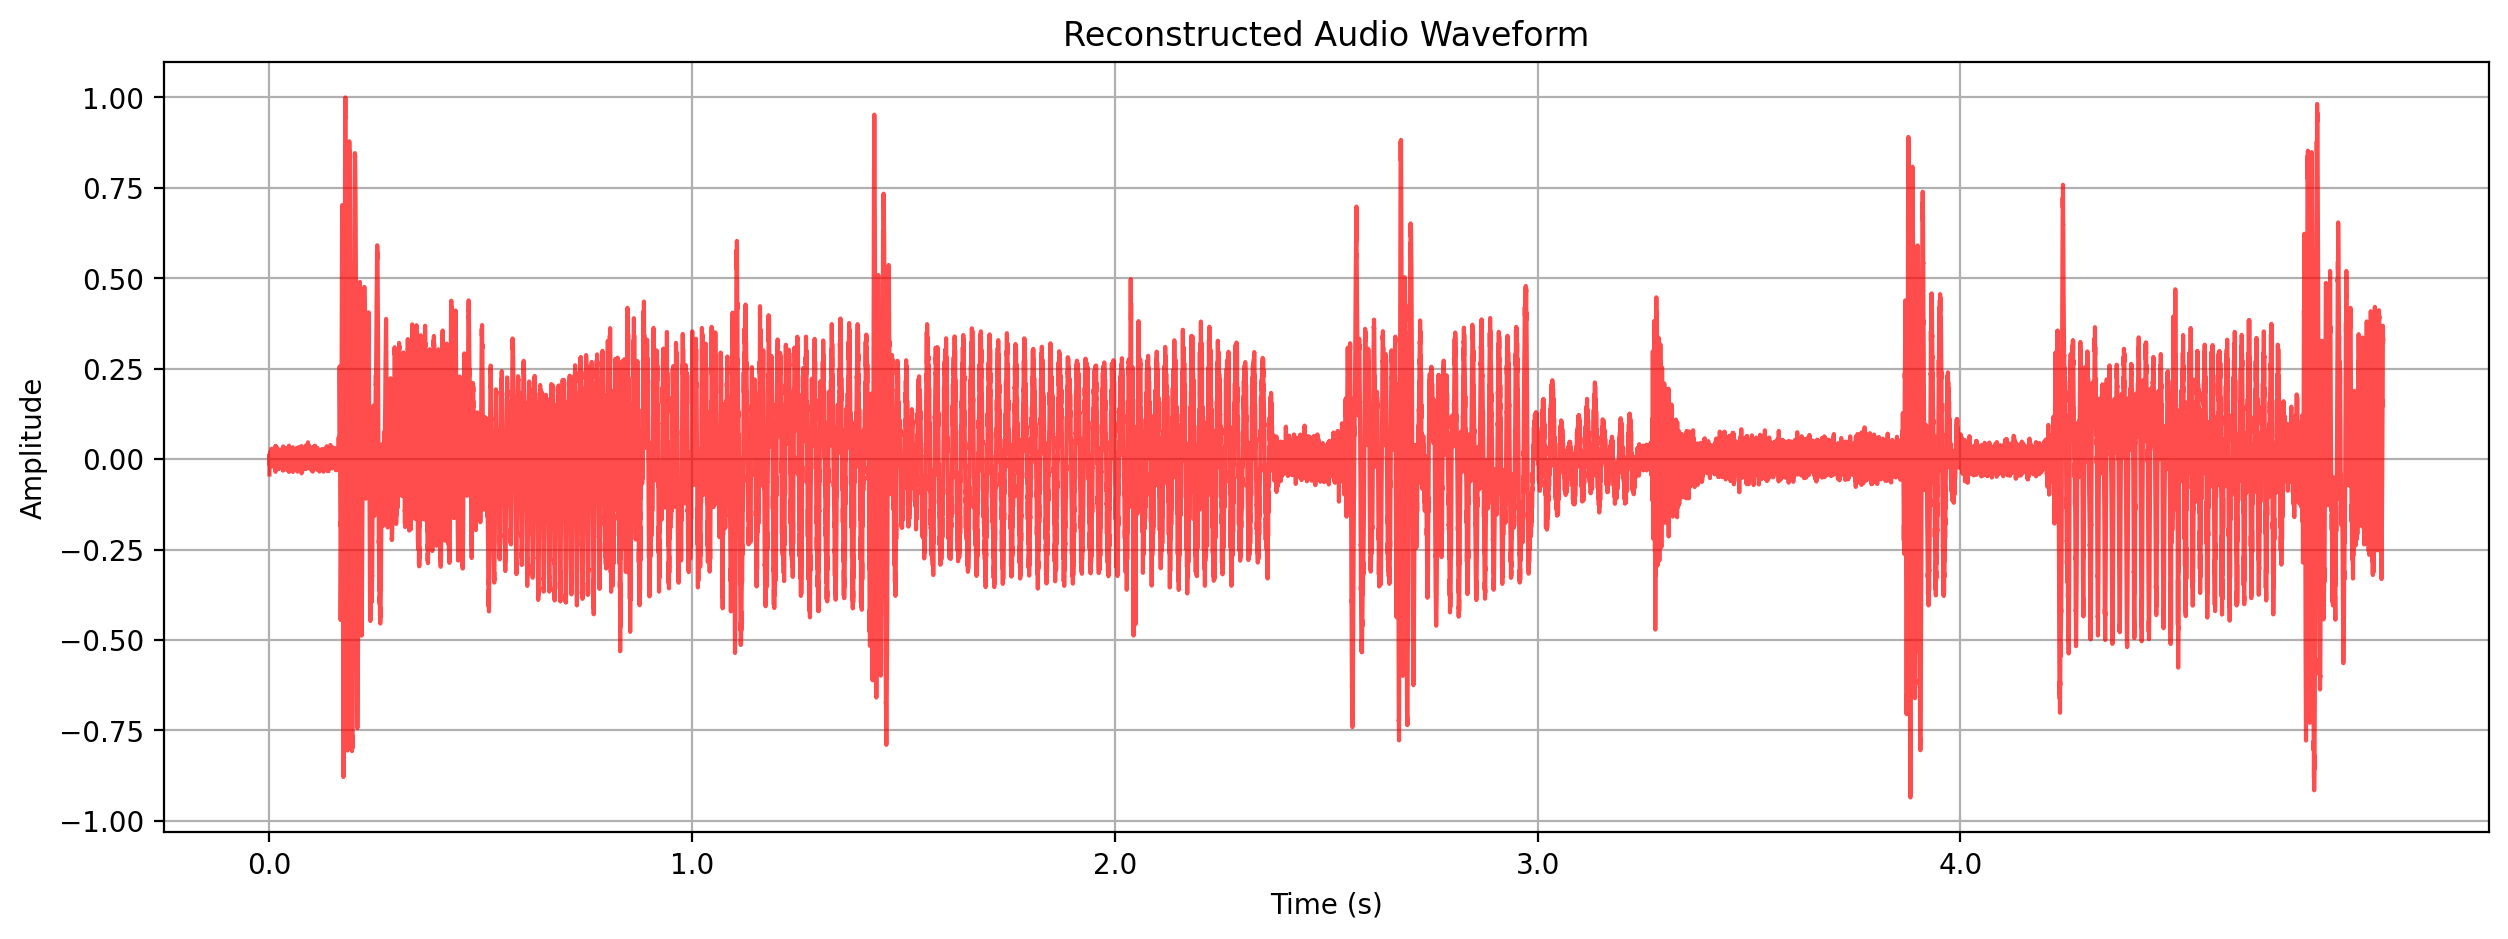

In [19]:
plot_audio(pred_audio, sample_rate, 'red', 'Reconstructed Audio Waveform')

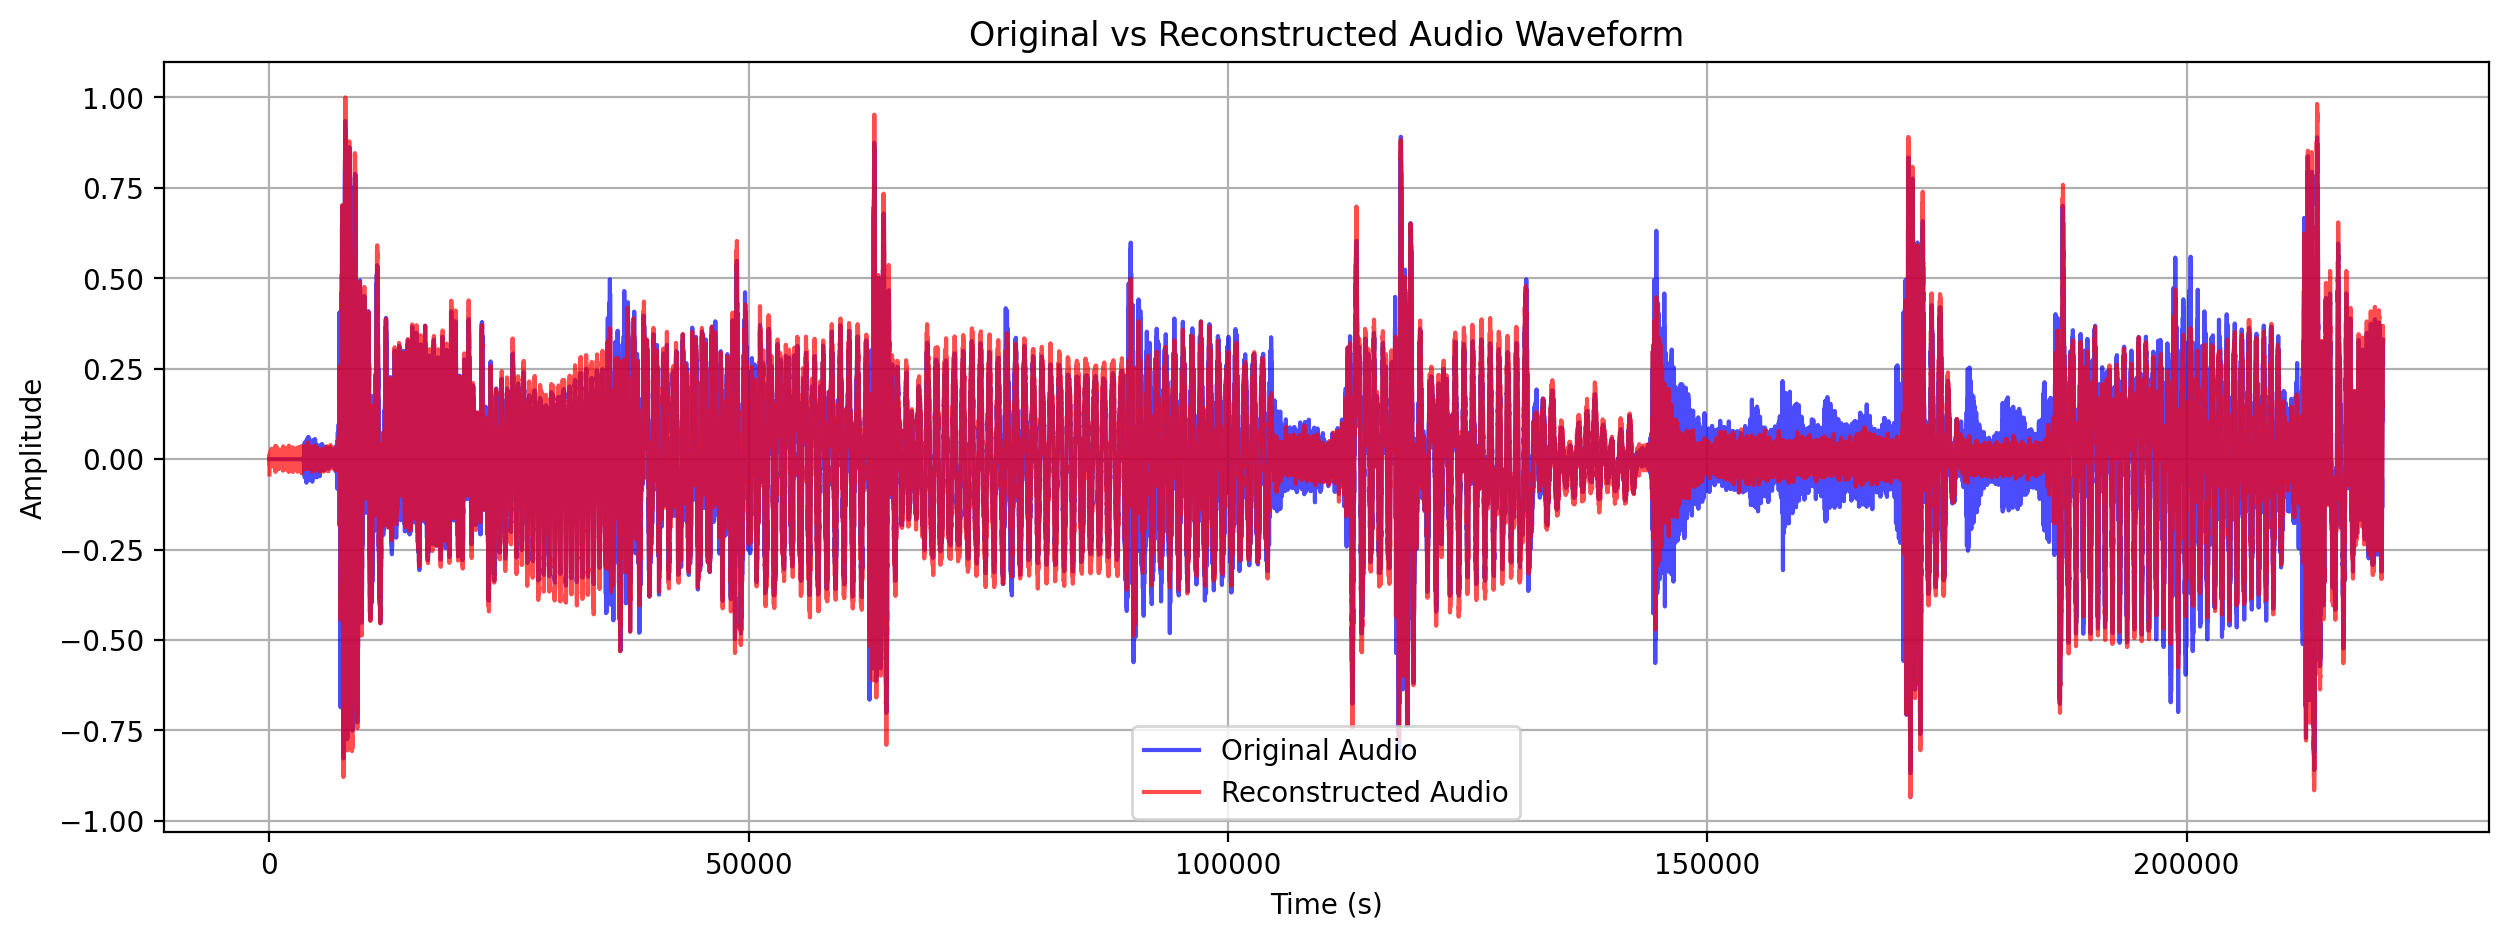

In [20]:
# Plotting both the original and reconstructed waveforms

plt.figure(figsize=(15, 5))
plt.plot(audio, color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [21]:
def snr(original_signal, predicted_signal):
    """
    original_signal (numpy.ndarray): The original audio signal.
    predicted_signal (numpy.ndarray): The predicted or reconstructed audio signal.
    

    float: The SNR value in dB.
    """
    # Ensure inputs are numpy arrays
    original_signal = np.asarray(original_signal)
    predicted_signal = np.asarray(predicted_signal)
    
    if original_signal.shape != predicted_signal.shape:
        raise ValueError("Original and predicted signals must have the same shape.")
    
    noise = original_signal - predicted_signal
    signal_power = np.mean(np.square(original_signal))
    noise_power = np.mean(np.square(noise))
    
    # Avoid division by zero
    if noise_power == 0:
        raise ValueError("Noise power is zero. SNR is undefined.")
    
    # Calculate SNR
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr

In [22]:
audio_arr = audio.cpu().numpy()
audio_arr = audio_arr.squeeze()
audio_arr.shape

(220500,)

In [23]:
RMSE = mean_squared_error(audio, pred_audio)**0.5
SNR = snr(audio_arr, pred_audio)

print(f"RMSE = {RMSE:.6f}")
print(f"SNR = {SNR:.6f} dB")

RMSE = 0.046631
SNR = 11.817050 dB
